# The Tampa Bay Times and school performance

**Story:** [The story](http://www.tampabay.com/projects/2015/investigations/pinellas-failure-factories/), and [a critique](https://rogueedu.blogspot.com/2015/08/fcat-reading-scores-only-two-of-five.html)

**Author:** A million people, but I believe Nathaniel Lash did the data analysis

**Topics:** Linear Regression, Residuals

**Datasets**

* **0066897-gr04_rsch_2014.xls:** 4th grader pass rates for standardized tests, from Florida Dept of Education
* **FRL-1314-School-Web-Survey-3-Final.xls:** Free and reduced price lunch data, from Florida Dept of Education
* **MembershipSchoolRaceGender1415.xls:** School population by gender, from Florida Dept of Education

# What's the story?

We're trying to see what kind of effect race and poverty have on school test score data. Their actual story doesn't include a regression, but they used one behind the scenes for research.

## Imports

You'll want pandas and seaborn. You'll want want to set pandas to display a lot of columns and rows at a time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
pd.options.display.max_columns = 200
# pd.reset_option('display.max_columns')

# Reading in our data

Read in the dataset, being sure to read in the district and school number as strings in case we need to merge on anything later. If pandas gets its way, it would read them in as integers and turn `0001` into `1`. This dataset includes school information, as well as

* The percentage of students who passed their 4th grade standardized reading test
* The percentage of students receiving free or reduced price lunch, as a proxy for poverty
* The percentage of students that are Black/African-American

In [3]:
testing_df = pd.read_excel('sources/0066897-gr04_rsch_2014.xls', skiprows=10, \
                              usecols=['District Number','District Name','School Number','School Name','Number of Students','Percentage Passing (Achievement Levels 3 and Above)'], \
                              dtype={'District Number':str,'School Number':str})
testing_df = testing_df.rename({'Percentage Passing (Achievement Levels 3 and Above)':'Testing Pct Passing','Number of Students':'Testing Total'}, axis=1)
testing_df = testing_df.drop(testing_df.index[0:2])
testing_df = testing_df[testing_df['Testing Pct Passing'] != '*'].reset_index(drop=True)
testing_df[['Testing Total', 'Testing Pct Passing']] = testing_df[['Testing Total', 'Testing Pct Passing']].apply(pd.to_numeric) 
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 6 columns):
District Number        2079 non-null object
District Name          2079 non-null object
School Number          2079 non-null object
School Name            2079 non-null object
Testing Total          2079 non-null int64
Testing Pct Passing    2079 non-null int64
dtypes: int64(2), object(4)
memory usage: 65.0+ KB


In [4]:
lunches_df = pd.read_excel('sources/FRL-1314-School-Web-Survey-3-Final.xls', 'School', skiprows=4, dtype='str')
lunches_df = lunches_df.drop(lunches_df.index[0])
lunches_df = lunches_df[lunches_df['Total Members'] != '*'].reset_index(drop=True)
lunches_df = lunches_df.rename({'School #':'School Number','District':'District Name','Total Members':'Lunch Total','Eligible for Free or Reduced Price Lunch':'Lunch Free','Unnamed: 6':'Lunch Reduced','Unnamed: 7':'Lunch Prov2','Unnamed: 8':'Lunch DirCert'}, axis=1)
lunches_df[['Lunch Total','Lunch Free','Lunch Reduced','Lunch Prov2','Lunch DirCert']] = lunches_df[['Lunch Total','Lunch Free','Lunch Reduced','Lunch Prov2','Lunch DirCert']].apply(pd.to_numeric)
lunches_df['Lunch Pct Eligible'] = (((lunches_df['Lunch Free'] + lunches_df['Lunch Reduced'] + lunches_df['Lunch Prov2'] + lunches_df['Lunch DirCert']) / lunches_df['Lunch Total']) *100).round().astype(np.int64)
lunches_df['District Number'] = lunches_df['District Number'].str.zfill(2)
lunches_df['School Number'] = lunches_df['School Number'].str.zfill(4)
lunches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3903 entries, 0 to 3902
Data columns (total 10 columns):
District Number       3903 non-null object
District Name         3903 non-null object
School Number         3903 non-null object
School Name           3903 non-null object
Lunch Total           3903 non-null int64
Lunch Free            3903 non-null int64
Lunch Reduced         3903 non-null int64
Lunch Prov2           3903 non-null int64
Lunch DirCert         3903 non-null int64
Lunch Pct Eligible    3903 non-null int64
dtypes: int64(6), object(4)
memory usage: 244.0+ KB


In [5]:
demogr_df = pd.read_excel('sources/MembershipSchoolRaceGender1415.xls', 'SCHOOL', skiprows=4, dtype='str')
demogr_df = demogr_df[demogr_df['Grade'] == '4']
demogr_df = demogr_df[demogr_df['Total'] != '*'].reset_index(drop=True)
demogr_df = demogr_df.replace(r'^\s*$', '0', regex=True)
demogr_df = demogr_df.rename({'District #':'District Number','District':'District Name','School #':'School Number','School ':'School Name','Total':'Demog Total','White':'Demog White','Black or African American':'Demog Black','Hispanic/Latino':'Demog Hisp','Asian':'Demog Asian','Native Hawaiian or Other Pacific Islander':'Demog PI','American Indian or Alaska Native':'Demog NA','Two or More Races':'Demog Multi','Female Total':'Demog Female','Male Total':'Demog Male'}, axis=1)
demogr_df[['Demog Total','Demog White','Demog Black','Demog Hisp','Demog Asian','Demog PI','Demog NA','Demog Multi','Demog Female','Demog Male']] = demogr_df[['Demog Total','Demog White','Demog Black','Demog Hisp','Demog Asian','Demog PI','Demog NA','Demog Multi','Demog Female','Demog Male']].apply(pd.to_numeric)
demogr_df['Demog Pct White'] = ((demogr_df['Demog White'] / demogr_df['Demog Total']) *100).round().fillna(0).astype(np.int64)
demogr_df['Demog Pct Black'] = ((demogr_df['Demog Black'] / demogr_df['Demog Total']) *100).round().fillna(0).astype(np.int64)
demogr_df['Demog Pct Hisp'] = ((demogr_df['Demog Hisp'] / demogr_df['Demog Total']) *100).round().fillna(0).astype(np.int64)
demogr_df['Demog Pct Minority'] = (((demogr_df['Demog Total'] - demogr_df['Demog White']) / demogr_df['Demog Total']) *100).round().fillna(0).astype(np.int64)
demogr_df = demogr_df.drop('Grade', axis=1)
demogr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847 entries, 0 to 3846
Data columns (total 18 columns):
District Number       3847 non-null object
District Name         3847 non-null object
School Number         3847 non-null object
School Name           3847 non-null object
Demog White           3847 non-null int64
Demog Black           3847 non-null int64
Demog Hisp            3847 non-null int64
Demog Asian           3847 non-null int64
Demog PI              3847 non-null int64
Demog NA              3847 non-null int64
Demog Multi           3847 non-null int64
Demog Female          3847 non-null int64
Demog Male            3847 non-null int64
Demog Total           3847 non-null int64
Demog Pct White       3847 non-null int64
Demog Pct Black       3847 non-null int64
Demog Pct Hisp        3847 non-null int64
Demog Pct Minority    3847 non-null int64
dtypes: int64(14), object(4)
memory usage: 480.9+ KB


In [6]:
merge_df = testing_df
merge_df = merge_df.merge(lunches_df, how='left', left_on=['District Number','School Number'], right_on=['District Number','School Number'])
merge_df = merge_df.merge(demogr_df, how='inner', left_on=['District Number','School Number'], right_on=['District Number','School Number'])
merge_df = merge_df[['District Number','District Name_x','School Number','School Name_x','Testing Pct Passing','Lunch Pct Eligible','Demog Pct Black']]
merge_df = merge_df.rename({'District Name_x':'District Name','School Name_x':'School Name'}, axis=1)
# merge_df = merge_df.dropna(axis=0, how='any').reset_index(drop=True)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 7 columns):
District Number        2061 non-null object
District Name          2061 non-null object
School Number          2061 non-null object
School Name            2061 non-null object
Testing Pct Passing    2061 non-null int64
Lunch Pct Eligible     2061 non-null int64
Demog Pct Black        2061 non-null int64
dtypes: int64(3), object(4)
memory usage: 96.6+ KB


In [7]:
merge_df.sample(10)

,District Number,District Name,School Number,School Name,Testing Pct Passing,Lunch Pct Eligible,Demog Pct Black
575,13,MIAMI DADE,4221,PALMETTO ELEMENTARY SCHOOL,86,24,12
479,13,MIAMI DADE,1841,FLAGAMI ELEMENTARY SCHOOL,67,89,2
1227,41,MANATEE,0831,G.D. ROGERS GARDEN ELEMENTARY,32,96,40
868,28,HIGHLANDS,0015,MEMORIAL ELEMENTARY SCHOOL,44,85,22
692,16,DUVAL,0791,RAMONA BOULEVARD ELEMENTARY SCHOOL,24,78,55
863,27,HERNANDO,0321,SUNCOAST ELEMENTARY SCHOOL,63,61,3
2012,64,VOLUSIA,4531,SPRUCE CREEK ELEMENTARY SCHOOL,61,62,11
1222,41,MANATEE,0781,FREEDOM ELEMENTARY SCHOOL,67,52,9
437,13,MIAMI DADE,0641,BUNCHE PARK ELEMENTARY SCHOOL,47,97,70
1840,54,PUTNAM,0091,MELLON ELEMENTARY SCHOOL,33,91,57


### Converting to percentages

It's really easy to get mixed up later if we don't have our percentage columns as actual percents. Multiply any percentages that go 0-1 by 100 to turn them into 0-100 instead.

* **Tip:** Make sure your numbers are 1-100 after you multiply!

# Graphing our data

Use seaborn's `regplot` to plot the relationship between free/reduced lunch and percent passing, and the same with percent black.

* **Tip:** You can use `scatter_kws={'alpha':0.3}` to see things a bit more nicely

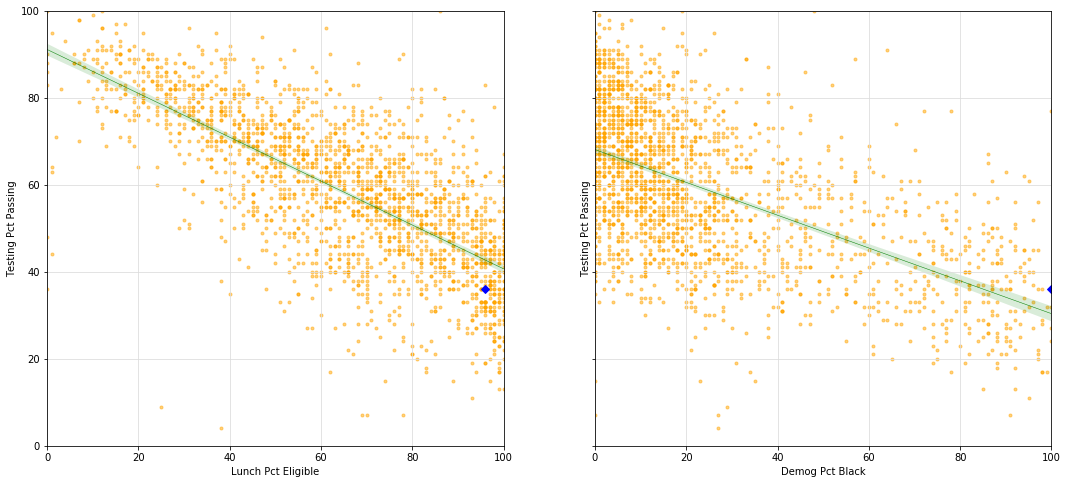

In [8]:
fig, (ax1, ax2) = plt.subplots(figsize=(18,8), ncols=2, sharey=True)
ax1.set_xlim(0,100)
ax1.set_ylim(0,100)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)
ax1.grid(True,color='gainsboro')
ax2.grid(True,color='gainsboro')
sns.regplot('Lunch Pct Eligible','Testing Pct Passing',data=merge_df,
            ax=ax1,
            marker='.',
            line_kws={'color':'green', 'linewidth':0.5},
            scatter_kws={'color':'orange', 'alpha':0.5})

sns.regplot('Demog Pct Black','Testing Pct Passing',data=merge_df,
            ax=ax2,
            marker='.',
            line_kws={'color':'green', 'linewidth':0.5},
            scatter_kws={'color':'orange', 'alpha':0.5})
CWDelem = merge_df.loc[0]
ax1.plot(CWDelem['Lunch Pct Eligible'], CWDelem['Testing Pct Passing'],'bD')
ax2.plot(CWDelem['Demog Pct Black'], CWDelem['Testing Pct Passing'],'bD')

# Linear regression

Now let's be a little more exact: run a linear regression that takes into account both percent black and percent free or reduced.

* **Tip:** Use `.dropna()` to remove missing data
* **Tip:** Remember to use `sm.add_constant`!

In [9]:
X = merge_df[['Lunch Pct Eligible','Demog Pct Black']]
X = sm.add_constant(X)
Y = merge_df['Testing Pct Passing']               

mod = sm.OLS(Y,X)
res = mod.fit()
res.summary()

C:\Program Files (x86)\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Testing Pct Passing   R-squared:                       0.581
Model:                             OLS   Adj. R-squared:                  0.580
Method:                  Least Squares   F-statistic:                     1425.
Date:                 Sun, 21 Jul 2019   Prob (F-statistic):               0.00
Time:                         02:54:37   Log-Likelihood:                -7903.2
No. Observations:                 2061   AIC:                         1.581e+04
Df Residuals:                     2058   BIC:                         1.583e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 89.6734      0.700    128.154      0.000      88.301      91.046
Lunch Pct Eligible    -0.4041      0.011    -35.331      0.000      -0.427      -0.382
Demog Pct Black       -0.1987      0.011    -18.584      0.000      -0.220      -0.178
==============================================================================
Omnibus:                      156.789   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              437.920
Skew:                          -0.402   Prob(JB):                     8.07e-96
Kurtosis:                       5.110   Cond. No.                         213.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Describe the relationship coefficient using "real" words

For example, "For every X change, we get Y change"

# Overperformers and underperformers

The point of the regression is to predict the percent passing, right? We can use `result.predict()` to get the predicted passing rate for each school. Try to run it below: 

Now, let's **save that value into a new column**, we can call it `predicted_passing`.

In [10]:
merge_df['Testing Predict Passing'] = res.predict().round(1)

In [11]:
merge_df.sample(10)

,District Number,District Name,School Number,School Name,Testing Pct Passing,Lunch Pct Eligible,Demog Pct Black,Testing Predict Passing
1741,52,PINELLAS,4771,WESTGATE ELEMENTARY SCHOOL,61,49,18,66.3
1540,50,PALM BEACH,0931,J. C. MITCHELL ELEMENTARY SCHOOL,64,64,17,60.4
1497,50,PALM BEACH,0011,HIDDEN OAKS ELEMENTARY SCHOOL,65,63,40,56.3
310,08,CHARLOTTE,0141,MEADOW PARK ELEMENTARY SCHOOL,59,69,13,59.2
424,13,MIAMI DADE,0361,BISCAYNE GARDENS ELEMENTARY,38,93,80,36.2
1067,33,JEFFERSON,0111,JEFFERSON COUNTY ELEM. SCHOOL,36,70,72,47.1
1003,29,HILLSBOROUGH,4361,THONOTOSASSA ELEMENTARY SCHOOL,41,93,20,48.1
136,06,BROWARD,0271,DILLARD ELEMENTARY SCHOOL,39,99,94,31.0
1245,42,MARION,0341,OAKCREST ELEMENTARY SCHOOL,33,73,41,52.0
249,06,BROWARD,3631,PARKSIDE ELEMENTARY SCHOOL,57,66,29,57.2


### Confirm that Charles W. Duval had a predicted passing rate of 32.

In [12]:
merge_df[merge_df['School Name'].str.contains("CHARLES W. DUVAL")]

,District Number,District Name,School Number,School Name,Testing Pct Passing,Lunch Pct Eligible,Demog Pct Black,Testing Predict Passing
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36,96,100,31.0


## Now let's find the difference between the predicted passing rate and the actual passing rate

If we're being stats-y, this is called **the residual**. Save it into a new column called.... `residual`.

* **Tip:** Think real hard about which direction you should be subtracting in.

In [13]:
merge_df['Residual'] = (merge_df['Testing Pct Passing'] - merge_df['Testing Predict Passing'])

### Find the 10 schools that did much worse than predicted

* PRINCETON HOUSE CHARTER should be the worst, with PEPIN ACADEMIES below that

In [14]:
merge_df.sort_values('Residual').head(10)

,District Number,District Name,School Number,School Name,Testing Pct Passing,Lunch Pct Eligible,Demog Pct Black,Testing Predict Passing,Residual
1021,29,HILLSBOROUGH,6609,PEPIN ACADEMIES,4,38,27,69.0,-65.0
1325,48,ORANGE,0055,PRINCETON HOUSE CHARTER,9,25,29,73.8,-64.8
1838,53,POLK,9203,B.E.S.T.,7,70,0,61.4,-54.4
2053,68,FSDB,0011,DEAF ELEMENTARY SCHOOL (FSDB),7,69,27,56.4,-49.4
1338,48,ORANGE,0185,RENAISSANCE CHTR SCH AT CHICKASAW,44,1,7,87.9,-43.9
838,22,GLADES,0056,PEMAYETV EMAHAKV CHARTER OUR WAY SC,48,0,0,89.7,-41.7
1709,52,PINELLAS,2441,CHI CHI RODRIQUEZ ACADEMY,15,74,23,55.2,-40.2
1330,48,ORANGE,0090,UCP EAST CHARTER,35,40,8,71.9,-36.9
1805,53,POLK,1351,POLK AVENUE ELEMENTARY SCHOOL,22,66,21,58.8,-36.8
1699,52,PINELLAS,1811,HIGH POINT ELEMENTARY SCHOOL,27,58,16,63.1,-36.1


### Find the top 10 schools that did better than predicted

* PARKWAY MIDDLE SCHOOL should be the best, and PATHWAYS should be second

In [15]:
merge_df.sort_values('Residual', ascending=False).head(10)

,District Number,District Name,School Number,School Name,Testing Pct Passing,Lunch Pct Eligible,Demog Pct Black,Testing Predict Passing,Residual
153,06,BROWARD,0701,PARKWAY MIDDLE SCHOOL,100,86,48,45.4,54.6
289,06,BROWARD,5372,PATHWAYS ACADEMY K-8 CENTER,83,96,52,40.5,42.5
630,13,MIAMI DADE,5131,N DADE CENTER FOR MODERN LANGUAGE,89,77,57,47.2,41.8
536,13,MIAMI DADE,3101,FRANK CRAWFORD MARTIN K-8 CENTER,91,54,64,55.1,35.9
2059,74,FAMU LAB SCH,0351,FAMU DEVELOP RESEARCH,77,69,100,41.9,35.1
266,06,BROWARD,5021,SOMERSET NEIGHBORHOOD SCHOOL,77,74,78,44.3,32.7
1837,53,POLK,8121,HARTRIDGE ACADEMY,96,61,6,63.8,32.2
646,13,MIAMI DADE,5561,FRANCES S. TUCKER ELEM. SCHOOL,75,93,47,42.8,32.2
270,06,BROWARD,5031,CHARTER SCHOOL OF EXCELLENCE,77,75,72,45.1,31.9
452,13,MIAMI DADE,1001,CORAL PARK ELEMENTARY SCHOOL,90,78,0,58.2,31.8


# What problems might our analysis have?

We brought in two things we thought would do a good job covering socioeconomics and demographic patterns. What else might we be missing?

* **Tip:** Pay attention to the names of the schools